In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
df=pd.read_excel('C://Users//demey//Documents//2024-2025//Industry Project//Bariatric Project Study Data 2025_mod.xlsx', sheet_name='Sheet1')

In [75]:
core_X_data=df[['gender', 'age', 'height', 'weight', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt','procedure_category','antibiotics']].copy()
cm_cols= [col for col in df.columns if col.startswith('CM_')]

cm_data = df[cm_cols].fillna(0).astype(int)
cm_data
zero_only = [col for col in cm_data.columns if (cm_data[col] == 0).all()]
cm_data = cm_data.drop(columns=zero_only)

# finally, join the filtered CM_ data back into your core set
core_X_data = core_X_data.join(cm_data)
core_X_data.fillna(0, inplace=True)
print(core_X_data.isna().sum())  # should all be zero

# inspect result
print("Dropped CM columns:", zero_only)
print("Remaining columns in CM data:", cm_data.columns.tolist())

gender                0
age                   0
height                0
weight                0
bmi                   0
family_hist_cnt       0
chronic_meds_cnt      0
procedure_category    0
antibiotics           0
CM_AIDS               0
CM_ANEMDEF            0
CM_ARTH               0
CM_CHF                0
CM_DEPRESS            0
CM_DM                 0
CM_DMCX               0
CM_HTN_C              0
CM_HYPOTHY            0
CM_LIVER              0
CM_OBESE              0
CM_PSYCH              0
CM_SMOKE              0
CM_APNEA              0
CM_CHOLSTRL           0
CM_OSTARTH            0
CM_HPLD               0
dtype: int64
Dropped CM columns: ['CM_ALCOHOL', 'CM_BLDLOSS', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DRUG', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_PARA', 'CM_PERIVASC', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS']
Remaining columns in CM data: ['CM_AIDS', 'CM_ANEMDEF', 'CM_ARTH', 'CM_CHF', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_HTN_C', 

In [76]:
#Add intra-operative columns
intra_op_cols = ['cvp', 'cvp_a_line', 'cvp_catheter', 'cvp_dvt_pumps','stapling', 'peritoneal_defects', 'bloodloss', 'bloodloss_amt', 'sheath_closure', 'sheath_closure_option', 'TheaterTotalTime', 'SurgeryTotalTime', 'wound_closure', 'post_op', 'regional_block', 'approach', 'drain','common_channel_length', 'billiary_limb_length','allimentary_limb_length','total_bowel_length', 'cholecystectomy_repair', 'incisional_hernia_repair','hiatus_hernia_repair']
intra_op_data = df[intra_op_cols].copy()

MISSING VALUES ANALYSIS
Columns with missing values: 4/24
Total completeness: 94.9%

Top missing columns:
                    Missing_Count  Missing_Percentage
bloodloss_amt                 189           54.941860
regional_block                156           45.348837
peritoneal_defects             64           18.604651
approach                       14            4.069767


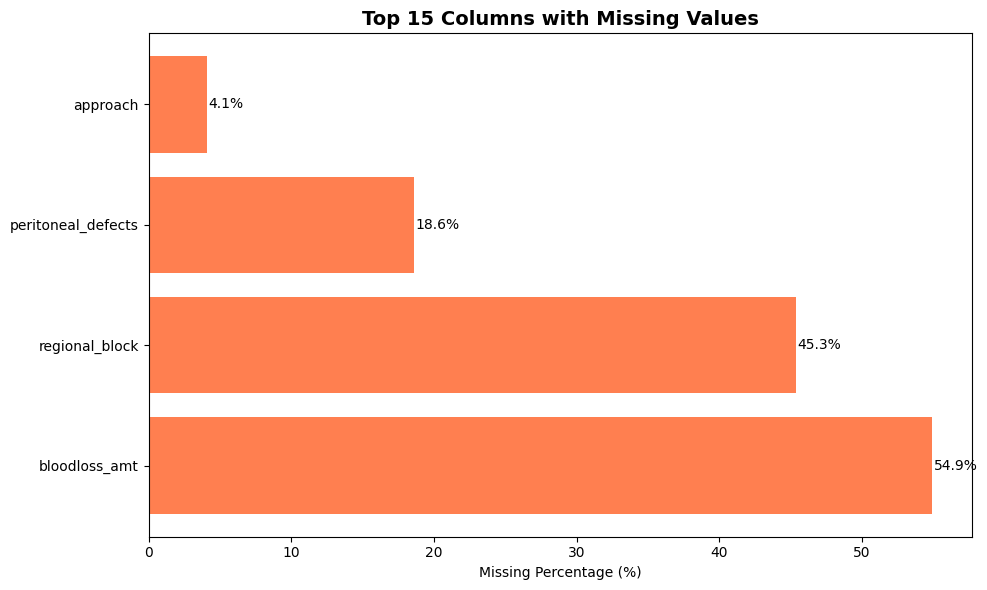

In [77]:
# Missing values analysis
missing_df = pd.DataFrame({
    'Missing_Count': intra_op_data.isnull().sum(),
    'Missing_Percentage': (intra_op_data.isnull().sum() / len(intra_op_data)) * 100
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)
print(f"Columns with missing values: {len(missing_df)}/{intra_op_data.shape[1]}")
print(f"Total completeness: {(1 - intra_op_data.isnull().sum().sum()/(intra_op_data.shape[0]*intra_op_data.shape[1]))*100:.1f}%")

if len(missing_df) > 0:
    print("\nTop missing columns:")
    print(missing_df.head(10))
    
    # Visualization
    plt.figure(figsize=(10, 6))
    top_missing = missing_df.head(15)
    plt.barh(range(len(top_missing)), top_missing['Missing_Percentage'], color='coral')
    plt.yticks(range(len(top_missing)), top_missing.index)
    plt.xlabel('Missing Percentage (%)')
    plt.title('Top 15 Columns with Missing Values', fontsize=14, fontweight='bold')
    
    for i, v in enumerate(top_missing['Missing_Percentage']):
        plt.text(v + 0.1, i, f'{v:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found!")

In [78]:
intra_op_data['bloodloss_amt'] = intra_op_data['bloodloss_amt'].fillna(0)
intra_op_data['approach'] = intra_op_data['approach'].fillna('Open')

In [79]:
intra_op_data.head(300)

,cvp,cvp_a_line,cvp_catheter,cvp_dvt_pumps,stapling,peritoneal_defects,bloodloss,bloodloss_amt,sheath_closure,sheath_closure_option,...,regional_block,approach,drain,common_channel_length,billiary_limb_length,allimentary_limb_length,total_bowel_length,cholecystectomy_repair,incisional_hernia_repair,hiatus_hernia_repair
0,0,0,0,1,Covidien,Prolene,1,100.0,0,PDS,...,TAPP,Laproscopic,1,300,0,0,0,0,0,0
1,0,0,0,0,Echelon,Prolene,0,0.0,0,PDS,...,TAPP,Laproscopic,0,0,0,0,0,1,0,0
2,0,0,0,1,Panther,Prolene,0,0.0,1,PDS,...,TAPP,Laproscopic,1,300,0,0,0,0,0,1
3,0,0,0,0,Panther,NaN,0,0.0,0,PDS,...,NaN,Laproscopic,0,0,0,0,0,0,0,1
4,0,0,1,1,Panther,Prolene,1,250.0,1,PDS,...,TAPP,Laproscopic,1,300,570,0,870,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,0,0,0,Covidien,Prolene,0,0.0,0,PDS,...,NaN,Open,0,0,200,0,0,0,0,0
296,0,0,0,1,Panther,Prolene,1,100.0,1,PDS,...,TAPP,Laproscopic,1,300,0,0,0,1,0,1
297,0,0,0,1,Covidien,NaN,0,0.0,0,PDS,...,NaN,Laproscopic,0,0,220,0,0,0,0,0
298,0,0,0,1,Covidien,Prolene,0,0.0,1,PDS,...,TAPP,Laproscopic,1,300,0,0,0,0,0,1


In [80]:
core_X_data = core_X_data.join(intra_op_data)
core_X_data

,gender,age,height,weight,bmi,family_hist_cnt,chronic_meds_cnt,procedure_category,antibiotics,CM_AIDS,...,regional_block,approach,drain,common_channel_length,billiary_limb_length,allimentary_limb_length,total_bowel_length,cholecystectomy_repair,incisional_hernia_repair,hiatus_hernia_repair
0,Female,50,154,146.0,61.56,0,0,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,0,0,0,0,0,0
1,Female,52,168,96.0,34.00,0,0,Sleeve,Kefsol,0,...,TAPP,Laproscopic,0,0,0,0,0,1,0,0
2,Female,23,163,143.0,53.82,0,0,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,0,0,0,0,0,1
3,Female,23,176,120.0,38.74,0,0,Sleeve,Kefsol,0,...,NaN,Laproscopic,0,0,0,0,0,0,0,1
4,Female,57,162,112.0,42.68,0,7,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,570,0,870,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,Female,24,173,145.0,48.45,0,0,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,320,0,620,0,0,1
340,Female,26,149,73.4,33.06,0,0,Mini gastric bypass (OAGB),Augmentin,0,...,NaN,Laproscopic,0,700,220,0,0,0,0,0
341,Female,24,180,153.0,47.22,0,0,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,0,0,0,0,0,1
342,Female,25,165,154.0,56.57,0,0,RYGBP,Augmentin,0,...,NaN,Laproscopic,0,0,150,80,0,0,0,0


In [81]:
# Identify all complication-related columns
comp_cols = [col for col in df.columns if 'comp' in col.lower()]

# Create new dataset without the original complication columns
df_new = df.drop(columns=comp_cols)

# Add a single 'complication' column: 1 if any original comp column == 1, else 0
df_new['complication'] = (df[comp_cols] == 1).any(axis=1).astype(int)

# Display new dataset shape
print("New dataset shape (rows, columns):", df_new.shape)

# Show a sample of the new 'complication' column alongside the ID
# Show the first 10 rows of id and complication
print(df_new[['id', 'complication']].head(10))
print("First 15 column names:", df_new.columns.tolist())

New dataset shape (rows, columns): (344, 111)
        id  complication
0  45488.0             0
1      NaN             0
2  37462.0             1
3  40661.0             0
4      NaN             0
5  40699.0             0
6  38920.0             0
7  37827.0             0
8  47189.0             0
9      NaN             0
First 15 column names: ['doctor', 'procedure_category', 'hospitalDesc', 'hospital_wardDesc', 'days_since_admission', 'length_of_stay', 'gender', 'age', 'weight', 'height', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt', 'cm_count', 'morbidity', 'CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_SMOKE', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS', 'CM_APNEA', 'CM_CHOLSTRL', 'CM_OSTARTH', 'CM_HPLD', 'emergency_

In [82]:
core_Y_data=df_new[["complication"]]

core_Y_data.head()

,complication
0,0
1,0
2,1
3,0
4,0


In [83]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
X = core_X_data.copy()
y = core_Y_data['complication'].values

# Handle categorical variables first
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


X_encoded.head()

,age,height,weight,bmi,family_hist_cnt,chronic_meds_cnt,CM_AIDS,CM_ANEMDEF,CM_ARTH,CM_CHF,...,peritoneal_defects_Stratfix,peritoneal_defects_V-lock,sheath_closure_option_PDS,wound_closure_Monocryl,wound_closure_V lock,wound_closure_Vicryl Rapide,post_op_ICU,post_op_Ward,regional_block_TAPP,approach_Open
0,50,154,146.0,61.56,0,0,0,0,0,0,...,False,False,True,True,False,False,False,True,True,False
1,52,168,96.0,34.00,0,0,0,0,0,0,...,False,False,True,True,False,False,False,True,True,False
2,23,163,143.0,53.82,0,0,0,0,0,0,...,False,False,True,True,False,False,False,True,True,False
3,23,176,120.0,38.74,0,0,0,0,0,0,...,False,False,True,False,False,False,False,True,False,False
4,57,162,112.0,42.68,0,7,0,0,0,0,...,False,False,True,True,False,False,False,True,True,False


In [84]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import numpy as np

# Assume you have X and y ready
# X = ...
# y = ...

# Define stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Example: Random Forest with class_weight
rf_model = RandomForestClassifier(class_weight={0: 1, 1: 5}, random_state=42)

# Cross-validation scores (you can change scoring to 'roc_auc', 'f1', etc.)
scores = cross_val_score(rf_model, X, y, cv=cv, scoring='f1')

print(f"Random Forest CV F1 scores: {scores}")
print(f"Mean F1: {scores.mean():.4f}")

# Example: Logistic Regression with balanced class_weight
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
scores_log = cross_val_score(log_model, X, y, cv=cv, scoring='f1')
print(f"Logistic Regression CV F1 scores: {scores_log}")
print(f"Mean F1: {scores_log.mean():.4f}")

# Example: SVC with custom class_weight
svc_model = SVC(class_weight={0: 1, 1: 5}, random_state=42)
scores_svc = cross_val_score(svc_model, X, y, cv=cv, scoring='f1')
print(f"SVC CV F1 scores: {scores_svc}")
print(f"Mean F1: {scores_svc.mean():.4f}")


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\demey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\demey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\demey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py", line 360, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "c:\Users\demey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\demey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\demey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\demey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\demey\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Female'
